This notebook contains all our scripts for the poster presentation at the NeuroAI Conference.

### Imports and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [2]:
# stim_times: index at which stimulation occurred 
# ephys_array: array of Neurons_x_Samples (units = # of spikes) 
# img_array:  array of Neurons_x_Samples (units = dFF)
# stim_ID: Identity of a given stim (a = forward, b = reverse, c = random) 
# each index is 33ms

'''
3s after each stimulation, 100ms time bins
input summed dF/F
spikes 100ms

# 1 how well can we predict endogenous to endogenous: 3s after onset, -100 to +100 ms bins spikes as output.
    potential issue: Ca2+ decay issue! Temporal decorrelation by binarising at each onset time?
# 2 endogenous to stimulations: 30ms bins.

Off-target problems?
Recurrent networks?
'''

stim_time = np.load('./data/biological/stim_times.npy') # (300,)
ephys_array = np.load('./data/biological/ephys_array.npy') # (77, 94357)
img_array = np.load('./data/biological/img_array.npy') # (384, 94357)
stim_id = np.load('./data/biological/stim_ID.npy') # (300,)

n_neurons, total_time = ephys_array.shape
n_stims = stim_time.shape[0]

In [3]:
from utils import rbf_rate_convolution_2d
ephys_rates = rbf_rate_convolution_2d(ephys_array.T, sigma=0.1).T # [94257, 77]

# pad
one_sided_padding_steps = int((total_time - ephys_rates.shape[0]) / 2)
one_sided_paddings = torch.zeros(one_sided_padding_steps, int(ephys_rates.shape[1]))
ephys_rates = torch.vstack((one_sided_paddings,ephys_rates))
ephys_rates = torch.vstack((ephys_rates, one_sided_paddings))

img_array = img_array.T

assert ephys_rates.shape[0] == total_time
assert img_array.shape[0] == ephys_rates.shape[0]

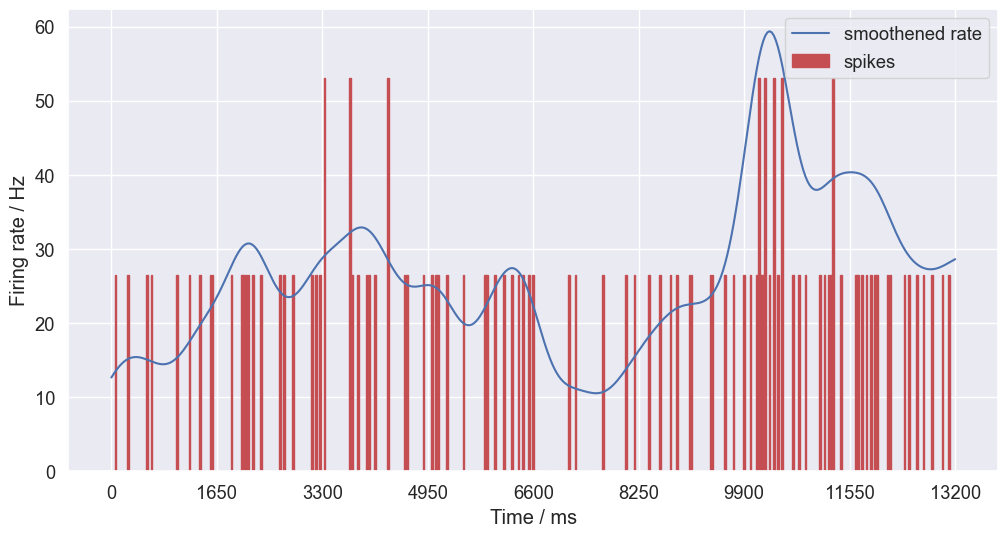

In [5]:
# plot a sample of ephys smooth rates
plt.figure(figsize=(12,6))
plt.plot(ephys_rates[50000:50401,15], label='smoothened rate')
plt.xticks(np.arange(0,401,50), [i*33 for i in range(0, 401, 50)])
plt.bar(np.arange(401), height = ephys_array[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

### Data Pre-processing
Process all input (GCaMP) data into independent tensors of length 15 (time steps) x 387 (input neurons) <br>
Process all output (EPhys) data into independent vectors of length 1 (time step) x 77 (output neurons)
The offset between input and output is -4 steps, found earlier by GLM. This is because there is a time delay in fluorescence decay.

In [6]:
tsteps = 15
cutoff_size = 2

assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [7]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

### Train for LS neurons only

In [8]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
# valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt: <br>
<ol>
  <li>d_model (int) – the number of expected features in the input (required).</li>
  <li>nhead (int) – the number of heads in the multiheadattention models (required).</li>
  <li>hidden_dim (int) – the dimension of the feedforward network model (default=2048).</li>
  <li>num_layers – the number of sub-encoder-layers in the encoder (required).</li>
</ol>

In [9]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


NameError: name 'valid_dataloader' is not defined

Train transformer

In [9]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 62        | -163.6    | 221.1     | 848.9     | 5.0       | 20.0      |
# | 57        | -164.1    | 270.0     | 876.5     | 3.016     | 16.14     |


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=220,
                    num_heads=20,
                    hidden_dim=848,
                    output_dim=output_dim,
                    n_layers=5,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

In [ ]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 220,
                    'num_heads': 20,
                    'hidden_dim': 848,
                    'output_dim': output_dim,
                    'n_layers': 5,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/LS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/LS-transformer-param.pkl')

Load best model parameters and show test losses

In [10]:
with open('./data/biological/trained_models/LS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_LS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,:13])
    print(LS_test_pred_loss.sum()/500/13)
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/13)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/13)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/13)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13)

tensor(164.9984)
Transformer prediction for forward stim MSE loss:  tensor(146.4460)
Transformer prediction for backward stim MSE loss:  tensor(174.5753)
Transformer prediction for random stim MSE loss:  tensor(170.0525)
Transformer prediction for non-stim stim MSE loss:  tensor(167.2906)


As a comparison, train GLM on each output neuron and show test losses

In [11]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])
output_dim = Y_test_LS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    
glm_loss = glm_LS_losses.sum() / Y_test_LS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

100%|██████████| 13/13 [04:14<00:00, 19.56s/it]

GLM with identity function loss:  203.74170461933716
GLM prediction for forward stim R2 loss:  199.0227219687733
GLM prediction for backward stim R2 loss:  202.1396938812515
GLM prediction for random stim R2 loss:  223.59592263523402
GLM prediction for non-stim stim R2 loss:  197.45097145948037


Loss as a function of data used

In [96]:
import random
a = random.sample([i for i in range(100)], 60)
len(a) == len(np.unique(a))

True

In [106]:
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

n_repeats = 10
batch_size = 4096
n_vecs = Y_train_LS.shape[0]

proportion_of_data = [0.05 * i for i in range(1,21)]
proportion_of_data_mean_losses = []
proportion_of_data_std_losses = []

from train import train_transformer
from sklearn.linear_model import TweedieRegressor

for i, proportion in enumerate(proportion_of_data):
    means = []
    for _ in range(n_repeats):
        
        rnd_idx = random.sample([i for i in range(n_vecs)], int(proportion * n_vecs))
        train_dataset = BNN_Dataset(X_train[rnd_idx, ...], Y_train_LS[rnd_idx, ...])
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
        
        _DNN_LS = TransformerDNN(input_dim=input_dim,
                        d_model=220,
                        num_heads=20,
                        hidden_dim=848,
                        output_dim=output_dim,
                        n_layers=5,
                        device=device,
                        pos_output=True,
                        use_mask=False,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
        
        optimiser = torch.optim.Adam(_DNN_LS.parameters(), lr=1e-3)
        criterion = nn.MSELoss(reduction='none')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                            mode='min', 
                                                            factor=0.5, 
                                                            patience=25, 
                                                            threshold=0.01)
        num_epochs = 500

        _return_dict = train_transformer(
                    model=_DNN_LS,
                    train_loader=train_dataloader,
                    test_loader=test_dataloader,
                    optimiser=optimiser,
                    criterion=criterion,
                    num_epochs=num_epochs,
                    verbose=False,
                    force_stop=False,
                    scheduler=scheduler,
                    use_wandb=False,
                    stim_type_indices=
                    [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])
        
        _DNN_LS.load_state_dict(_return_dict['best_eval_params'])

        with torch.no_grad():
            _Y_hat_LS = _DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
            _LS_test_pred_loss = nn.MSELoss(reduction='none')(_Y_hat_LS, Y_test[...,:13])
        
        
        # fit GLM with identity link function
        X_train_np = X_train[rnd_idx, ...].cpu().numpy().reshape(len(rnd_idx),-1)
        Y_train_LS_np = Y_train_LS[rnd_idx, ...].cpu().numpy().reshape(Y_train_LS[rnd_idx, ...].shape[0],-1) + 1e-6 # numerical stability

        X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
        Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


        # pred for each neuron
        _glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])

        for i in tqdm(range(output_dim)):
            _glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
            _glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
            
            _glm_LS_losses += np.power(Y_test_LS_np[:,i] - _glm_LS_reg.predict(X_test_np), 2)
            
        means.append([_LS_test_pred_loss[forward_mse_idx].sum().numpy()/len(forward_mse_idx)/13,
                                            _LS_test_pred_loss[backward_mse_idx].sum().numpy() / len(backward_mse_idx)/13,
                                            _LS_test_pred_loss[random_mse_idx].sum().numpy() / len(random_mse_idx)/13,
                                            _LS_test_pred_loss[non_stim_mse_idx].sum().numpy() / len(non_stim_mse_idx)/13,
                                            _glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/13,
                                            _glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/13,
                                            _glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/13,
                                            _glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13])
    proportion_of_data_mean_losses.append(np.mean(np.array(means), axis=0))
    proportion_of_data_std_losses.append(np.std(np.array(means), axis=0))
    

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWar

### Train for non-LS neurons only

In [12]:
Y_train_nLS = Y_train[..., 13:]
Y_test_nLS = Y_test[..., 13:]
# Y_valid_nLS = Y_valid[..., 13:]
output_dim = Y_train_nLS.shape[-1]

batch_size = 2048
train_dataset = BNN_Dataset(X_train, Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

# valid_dataset = BNN_Dataset(X_valid, Y_valid_nLS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt

In [ ]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=500,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

Train transformer

In [13]:
# TRANSFORMER
# | 67        | -240.9    | 992.8     | 923.3     | 2.437     | 19.03     |
# | 6         | -242.3    | 820.7     | 971.4     | 2.254     | 14.15     |
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=988,
                    num_heads=19,
                    hidden_dim=923,
                    output_dim=output_dim,
                    n_layers=2,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:

import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=[forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

In [ ]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 988,
                    'num_heads': 19,
                    'hidden_dim': 848,
                    'output_dim': output_dim,
                    'n_layers': 2,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/nLS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl')

Load best model parameters and show test losses

In [14]:
with open('./data/biological/trained_models/nLS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_nLS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,13:])
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Transformer prediction for forward stim MSE loss:  tensor(257.8112)
Transformer prediction for backward stim MSE loss:  tensor(237.3791)
Transformer prediction for random stim MSE loss:  tensor(253.9427)
Transformer prediction for non-stim stim MSE loss:  tensor(240.6133)


As a comparison, train GLM on each output neuron and show test losses

In [15]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]
print(output_dim)

from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros(Y_test_nLS_np.shape[0])
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)
    
glm_loss = glm_nLS_losses.sum() / Y_test_nLS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_nLS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

64


100%|██████████| 64/64 [20:49<00:00, 19.52s/it]

GLM with identity function loss:  242.20006976382567
GLM prediction for forward stim R2 loss:  256.24911905473385
GLM prediction for backward stim R2 loss:  236.44839018743764
GLM prediction for random stim R2 loss:  241.57772291497767
GLM prediction for non-stim stim R2 loss:  238.16813405253095


### Second dataset

In [12]:
area_idx = np.load('./data/biological/Aug23/area_idx.npy') # 92 neurons, idx 0-76 'LS', 77-91 'ACC'
ephys_array = np.load('./data/biological/Aug23/ephys_array.npy') # (92, 536020) at 1 ms
ephys_stim_a = np.load('./data/biological/Aug23/ephys_stim_a.npy') # type A stim timings, 50 in total
ephys_stim_b = np.load('./data/biological/Aug23/ephys_stim_b.npy') # type B stim timings, 50 in total
img_array = np.load('./data/biological/Aug23/img_array.npy') # (189, 19010)
img_stim_a = np.load('./data/biological/Aug23/img_stim_a.npy')
img_stim_b = np.load('./data/biological/Aug23/img_stim_b.npy')

In [14]:
# align timings
# img_array starts and then ephys.
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(img_stim_a.reshape(-1, 1), ephys_stim_a.reshape(-1, 1))
print(f'Linearity correlation: {reg.score(img_stim_a.reshape(-1, 1), ephys_stim_a.reshape(-1, 1))}')
offset = int(reg.intercept_.squeeze())
freq = reg.coef_.squeeze()
print(f'Offset between GCaMP and Neuropixel is {offset} ms.')
print(f'Sampling frequency for GCaMP is {freq} Hz.')

# the ephys starts first and imaging a bit later
ephys_array = ephys_array[:, offset:]
ephys_stim_a = np.array([a - offset for a in ephys_stim_a])
ephys_stim_b = np.array([b - offset for b in ephys_stim_b])
print(f'Total EPhys recording time: {ephys_array.shape[1]/1000} s')

Linearity correlation: 0.9999999965150472
Offset between GCaMP and Neuropixel is 7478 ms.
Sampling frequency for GCaMP is 33.29890144832494 Hz.
Total EPhys recording time: 528.542 s


In [37]:
img_array = img_array[:, :int(ephys_array.shape[1]/freq)]
img_array.shape

(189, 15872)

In [39]:
np.max(img_stim_a)

17157

In [38]:
# downsample ephys to 33 hertz
ephys_array_ds = np.zeros(ephys_array.shape[0]. img_array.shape[1])
for bin in range(img_array.shape[1]):
    ephys_array_ds[]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Poster graphs

### Example of GCaMP data

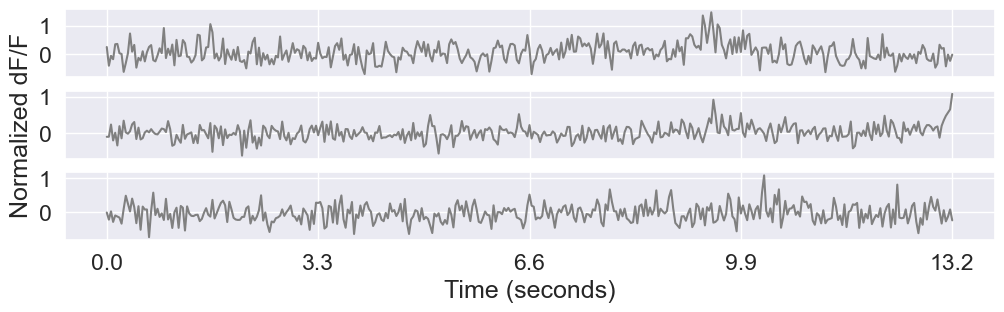

In [94]:
sns.set(font_scale=1.5)
f, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,3))

axes[0].plot(img_array[50000:50401,7], c='gray')

axes[1].plot(img_array[50000:50401,126], c='gray')
axes[1].set_ylabel('Normalized dF/F')


axes[2].plot(img_array[50000:50401,268], c='gray')
axes[2].set_xticks(np.arange(0,401,100), [i*33/1000 for i in range(0, 401, 100)])

plt.xlabel('Time (seconds)')
plt.savefig('./figures/sample_fluorescence', dpi=350, bbox_inches='tight')

plt.show()

### Example of EPhys data

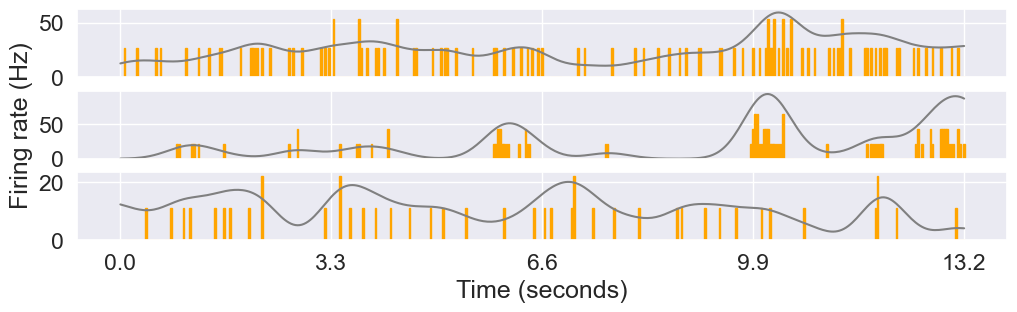

In [67]:
f, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,3))

axes[0].plot(ephys_rates[50000:50401,15], c='gray')
axes[0].bar(np.arange(401), height = ephys_array[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='orange', edgecolor='orange', label='spikes')

axes[1].plot(ephys_rates[50000:50401,67], c='gray')
axes[1].bar(np.arange(401), height = ephys_array[67, 50000:50401] * ephys_rates[50000:50401,67].mean().numpy(), color='orange', edgecolor='orange', label='spikes')
axes[1].set_ylabel('Firing rate (Hz)')

axes[2].plot(ephys_rates[50000:50401,3], c='gray')
axes[2].bar(np.arange(401), height = ephys_array[3, 50000:50401] * ephys_rates[50000:50401,3].mean().numpy(), color='orange', edgecolor='orange', label='spikes')
axes[2].set_xticks(np.arange(0,401,100), [i*33/1000 for i in range(0, 401, 100)])

plt.xlabel('Time (seconds)')
plt.savefig('./figures/sample_rates', dpi=350, bbox_inches='tight')

plt.show()

### Comparison of losses

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([77])) that is different to the input size (torch.Size([500, 1, 77])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


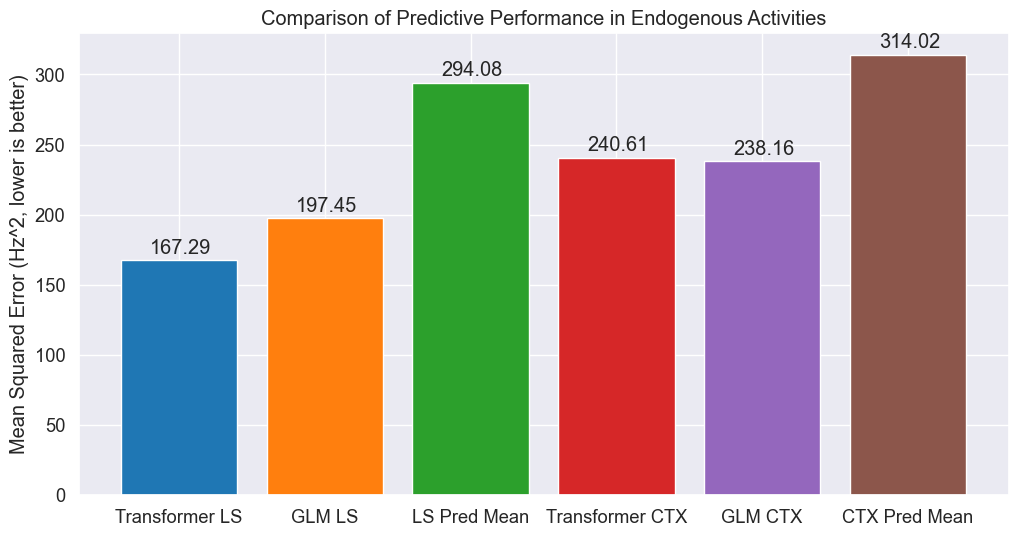

In [41]:
pred_mean_loss = nn.MSELoss(reduction='none')(Y_test, torch.mean(Y_train, dim=(0,1)))

endogenous_losses = np.array([
    LS_test_pred_loss[non_stim_mse_idx].sum()/len(non_stim_mse_idx)/13,
    glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13,
    pred_mean_loss[non_stim_mse_idx, :, :13].sum() / len(non_stim_mse_idx)/13,
    nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
    glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
        pred_mean_loss[non_stim_mse_idx, :, :64].sum() / len(non_stim_mse_idx)/64
])

sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
bars = plt.bar(np.arange(6), endogenous_losses, color=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b'])
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x()+  rect.get_width() / 4, height + 5, str(endogenous_losses[i])[:6])
plt.xticks(np.arange(6), ['Transformer LS', 'GLM LS', 'LS Pred Mean', 'Transformer CTX', 'GLM CTX', 'CTX Pred Mean'])
plt.ylabel('Mean Squared Error (Hz^2, lower is better)')
plt.title('Comparison of Predictive Performance in Endogenous Activities')
plt.savefig('./figures/endogenous_activities_comparison.png', dpi=350, bbox_inches='tight')
plt.show()

In [20]:
pred_mean_loss = nn.MSELoss(reduction='none')(Y_test, torch.mean(Y_train, dim=(0,1)))
pred_mean_loss.shape

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([77])) that is different to the input size (torch.Size([500, 1, 77])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([500, 1, 77])

#### Bar plots

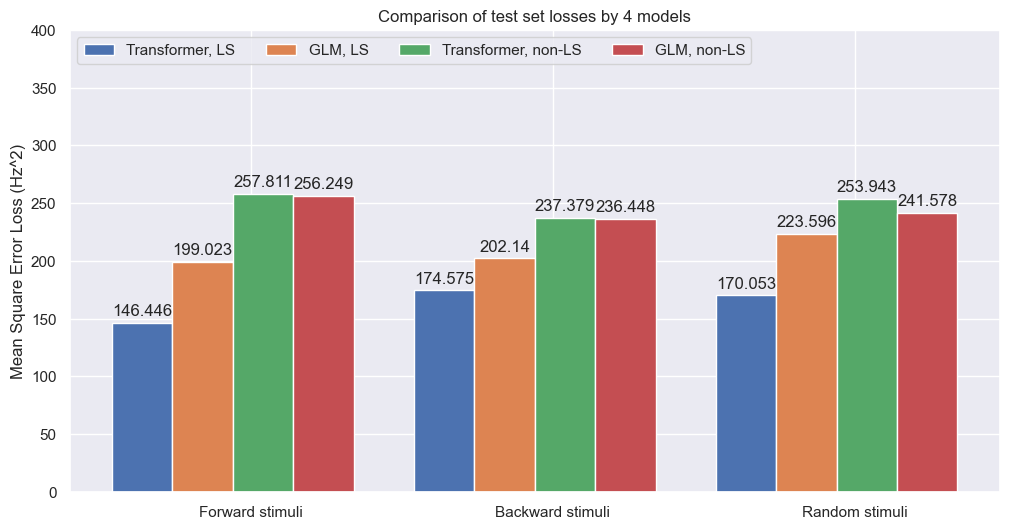

In [45]:
sns.set(font_scale=1.0)
stim_types = ['Forward stimuli', 'Backward stimuli', 'Random stimuli']
mses = {
    'Transformer, LS': (
                              LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/13,
                              LS_test_pred_loss[backward_mse_idx].sum()/len(backward_mse_idx)/13,
                              LS_test_pred_loss[random_mse_idx].sum()/len(random_mse_idx)/13),
    'GLM, LS': (
                      glm_LS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/13,
                      glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/13,
                      glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/13),
    'Transformer, non-LS': (
                                  nLS_test_pred_loss[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                                  nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                                  nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/64),
    'GLM, non-LS': (
                          glm_nLS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                          glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                          glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/64)
}

x = np.arange(len(stim_types))
width = 0.2  # the width of the bars
multiplier = -0.8
fig, ax = plt.subplots(figsize=(12,6))

for model, loss in mses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, loss, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Square Error Loss (Hz^2)')
ax.set_title('Comparison of test set losses by 4 models')
ax.set_xticks(x + width, stim_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 400)

plt.savefig('./figures/loss_bar_plot', bbox_inches='tight', dpi=350)
plt.show()


#### Violin plots

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
colors = ['r', 'b', 'b', 'b']

nstim_losses = [LS_test_pred_loss[non_stim_mse_idx].sum((1,2))/13, glm_LS_losses[non_stim_mse_idx]/13, nLS_test_pred_loss[non_stim_mse_idx].sum((1,2))/64, glm_nLS_losses[non_stim_mse_idx]/64]
vplots = axes[0,0].violinplot(nstim_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,0].set_xticks(np.arange(1,5), mses.keys())
axes[0,0].set_title('Endogenous activities', fontsize=12)
axes[0,0].set_ylabel('Mean Square Error Loss (Hz^2)')

forward_losses = [LS_test_pred_loss[forward_mse_idx].sum((1,2))/13, glm_LS_losses[forward_mse_idx]/13, nLS_test_pred_loss[forward_mse_idx].sum((1,2))/64, glm_nLS_losses[forward_mse_idx]/64]
vplots = axes[0,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,1].set_xticks(np.arange(1,5), mses.keys())
axes[0,1].set_title('Forward stimuli', fontsize=12)
axes[0,1].set_ylabel('Mean Square Error Loss (Hz^2)')


backward_losses = [LS_test_pred_loss[backward_mse_idx].sum((1,2))/13, glm_LS_losses[backward_mse_idx]/13, nLS_test_pred_loss[backward_mse_idx].sum((1,2))/64, glm_nLS_losses[backward_mse_idx]/64]
vplots = axes[1,0].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,0].set_xticks(np.arange(1,5), mses.keys())
axes[1,0].set_title('Backward activities', fontsize=12)
axes[1,0].set_ylabel('Mean Square Error Loss (Hz^2)')


random_losses = [LS_test_pred_loss[random_mse_idx].sum((1,2))/13, glm_LS_losses[random_mse_idx]/13, nLS_test_pred_loss[random_mse_idx].sum((1,2))/64, glm_nLS_losses[random_mse_idx]/64]
vplots = axes[1,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,1].set_xticks(np.arange(1,5), mses.keys())
axes[1,1].set_title('Random activities', fontsize=12)
axes[1,1].set_ylabel('Mean Square Error Loss (Hz^2)')

plt.savefig('./figures/violin_loss_plot', bbox_inches='tight', dpi=350)
plt.show()


### ACF in GCaMP

In [ ]:
def compute_acf(data, lag=0):
    '''
    Data: shape (time_steps, dim)
    '''
    mean_ts = torch.mean(data, axis=0)
    var_ts = torch.var(data, axis=0)
    ts_len = data.shape[0]

    autocorr = np.zeros(data.shape[1])

    for i in range(data.shape[1]):
        if lag == 0:
            autocorr[i] = 1  # Autocorrelation at lag 0 is always 1
        else:
            autocorr[i] = torch.sum((data[:ts_len - lag, i] - mean_ts[i]) *
                                 (data[lag:, i] - mean_ts[i])) / (var_ts[i] * (ts_len - lag))
    return autocorr

img_array_acfs = np.array([compute_acf(img_array, lag=i) for i in range(0,41)]).T
plt.figure(figsize=(12, 8))
sns.heatmap(img_array_acfs, cmap='viridis')
plt.xlabel('Lag')
plt.yticks(np.linspace(0, img_array.shape[1], 10), map(int, np.linspace(0, img_array.shape[1], 10)))
plt.ylabel('HPC Neuron index')
plt.title('Heatmap of HPC All-Optical Autocorrelation')
plt.savefig('./figures/acf_img_array', bbox_inches='tight', dpi=350)
plt.show()

### Attention maps in the Encoder Layers

In [ ]:
'''
NOTE BY DANIEL

In order to extract attention weights we need to tweak the torch source code.
Go to torch.nn.modules.transformer
and set all key worded arguments when forward-passing the MultiHeadAttention module
needs_weight False -> True
then attack the following hook
'''
def get_attention_hook(attention_weights_dict, layer_name):
    def hook(module, input, output):
        if len(output) == 2:
            attention_weights_dict[layer_name] = output[1].detach()
    return hook

attention_weights_dict = {}

for name, module in DNN_LS.named_modules():
    if isinstance(module, 
                  torch.nn.MultiheadAttention):
        hook = get_attention_hook(attention_weights_dict, name)
        module.register_forward_hook(hook)
        
with torch.no_grad():
    Y_test_nLS_hat = DNN_LS(X_test.permute(1,0,2).to(device))

In [ ]:
# plot average attention map for each layer

f, axes = plt.subplots(ncols=5, nrows=1, sharey=True, figsize=(20,5))
for layer, attn_w in enumerate(attention_weights_dict.values()):
    m = axes[layer].matshow(torch.mean(attn_w, dim=0).cpu().numpy(), cmap='Blues')
    f.colorbar(m, shrink=0.7)
    axes[layer].set_xticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_yticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_title(f'Attention map for layer {layer+1}')

plt.savefig('./figures/attn_maps', bbox_inches='tight', dpi=350)
plt.show()

### Optimal Prediction offset steps

In [ ]:
tsteps = 15
assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)

sweeplen = tsteps * 4
glm_loss_sweep = np.zeros((599, output_dim, sweeplen))

for s, loc in tqdm(enumerate(range(-4*tsteps, 4*tsteps, 1))):
    # begin sweep
    for n in range(2, n_vecs-2):
        inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
        targets[n,:,:] = ephys_rates[n*tsteps+loc:n*tsteps+loc+1,:]

    stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
    non_stim_vecs_idx = [i for i in range(4, n_vecs-4) if i not in stim_vecs_idx] # exclude padding steps

    # exogenous as test dataset
    X_test, Y_test = inputs[stim_vecs_idx], targets[stim_vecs_idx]
    X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]

    from utils import randomise_dataset_split
    X_train, X_test_non_stim, X_valid, Y_train, Y_test_non_stim, Y_valid = randomise_dataset_split(X, Y, split_ratio=(0.85,0.05,0.1))
    X_test, Y_test = torch.vstack((X_test, X_test_non_stim)), torch.vstack((Y_test, Y_test_non_stim))
    
    # fit GLM
    X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
    Y_train_np = Y_train.cpu().numpy().reshape(Y_train.shape[0],-1) + 1e-6 # numerical stability

    X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
    Y_test_np = Y_test.cpu().numpy().reshape(Y_test.shape[0],-1) + 1e-6 # numerical stability

    from sklearn.linear_model import TweedieRegressor

    # pred for each neuron
    glm_losses = np.zeros(Y_test_np.shape[0])
    output_dim = Y_test_np.shape[1]

    for i in range(output_dim):
        glm_reg = TweedieRegressor(power=0, alpha=1, link='identity')
        glm_reg.fit(X_train_np, Y_train_np[:,i])
        
        R2_loss = np.power(Y_test_np[:,i] - glm_reg.predict(X_test_np), 2)
        glm_losses += R2_loss
        glm_loss_sweep[:, i, s] = R2_loss
    print(f'GLM with identity link function loss on step {s}: {glm_losses.sum() / Y_test.shape[0] / output_dim}')

In [ ]:
# plot GLM loss wrt offset
plt.plot(glm_loss_sweep.sum(1).sum(0)/599/77)
plt.xticks(np.arange(0, tsteps * 4, 5), np.arange(- 2*tsteps, 2*tsteps, 5))
plt.xlabel('EPhys vs GCaMP Offset')
plt.ylabel('GLM R2 loss')
plt.show()

### Data Efficiency

In [128]:
np.save('./proportion_of_data_mean_losses.npy', proportion_of_data_mean_losses)
np.save('./proportion_of_data_std_losses.npy', proportion_of_data_std_losses)

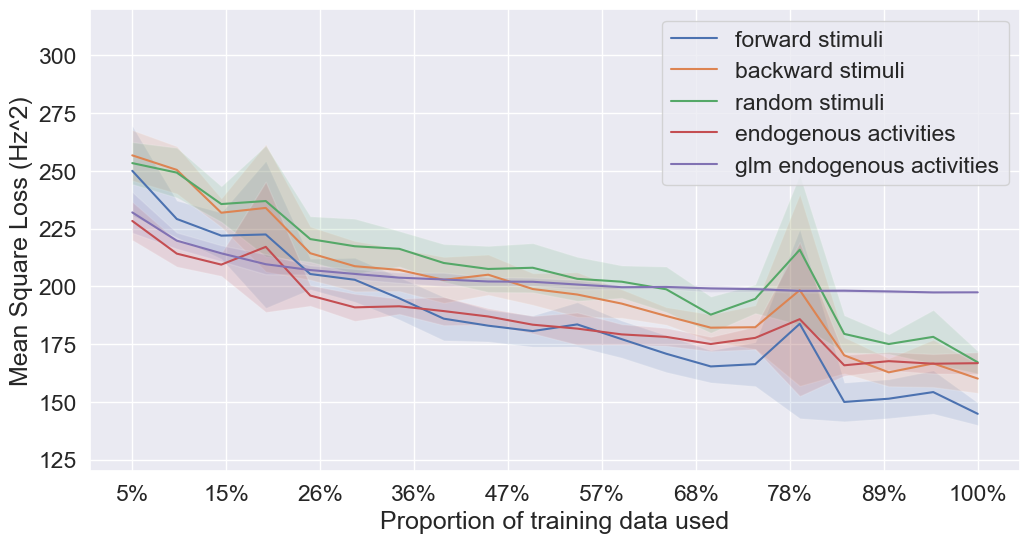

In [127]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,6))
plt.plot([np.array(i[0]) for i in proportion_of_data_mean_losses], label='forward stimuli')
plt.fill_between(np.arange(20), np.array([np.array(i[0]) for i in proportion_of_data_mean_losses]) - [np.array(i[0]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[0]) for i in proportion_of_data_mean_losses]) + [np.array(i[0]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[1]) for i in proportion_of_data_mean_losses], label='backward stimuli')
plt.fill_between(np.arange(20), np.array([np.array(i[1]) for i in proportion_of_data_mean_losses]) - [np.array(i[1]) for i in proportion_of_data_mean_losses],
                 np.array([np.array(i[1]) for i in proportion_of_data_mean_losses]) + [np.array(i[1]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[2]) for i in proportion_of_data_mean_losses], label='random stimuli')
plt.fill_between(np.arange(20), np.array([np.array(i[2]) for i in proportion_of_data_mean_losses]) - [np.array(i[2]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[2]) for i in proportion_of_data_mean_losses]) + [np.array(i[2]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[3]) for i in proportion_of_data_mean_losses], label='endogenous activities')
plt.fill_between(np.arange(20), np.array([np.array(i[3]) for i in proportion_of_data_mean_losses]) - [np.array(i[3]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[3]) for i in proportion_of_data_mean_losses]) + [np.array(i[3]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.plot([np.array(i[-1]) for i in proportion_of_data_mean_losses], label='glm endogenous activities')
plt.fill_between(np.arange(20), np.array([np.array(i[-1]) for i in proportion_of_data_mean_losses]) - [np.array(i[-1]) for i in proportion_of_data_std_losses],
                 np.array([np.array(i[-1]) for i in proportion_of_data_mean_losses]) + [np.array(i[-1]) for i in proportion_of_data_std_losses], alpha=0.15)
plt.legend()
plt.xticks(np.linspace(0, 19, 10), [str(int(i*100))+'%' for i in np.linspace(0.05,1,10)])
plt.xlabel('Proportion of training data used')
plt.ylabel('Mean Square Loss (Hz^2)')
plt.ylim([120, 320])
plt.savefig('./figures/data_efficiency', dpi=350, bbox_inches='tight')
plt.show()